## Libraries used
This demonstration uses scipy for its non-linear solver.  For machine learning components, it uses torch, gymnasium, and stable-baselines3.  Additional libraries may be imported to assist with evaluation or presentation of results.

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [2]:
import yfinance as yf

In [3]:
import gymnasium as gym
from gymnasium import spaces

In [4]:
import torch as th

In [6]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [7]:
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

## Data needed
In practice, one would likely use historical market data to build models.  This poses many challenges, as large and robust datasets are often currated by vendors.  Some free options are available, (especially outside of commercial use).  However, to prove out a machine learning approach, using simulated data is often useful.

Note that for machine learning applications using historical market data, there are often complexities related to how data is sampled.  If one is not careful, it is easy to overfit to limited historical data.

In [8]:
def generate_market_params(assets, N, seed=None):
    if not seed is None:
        np.random.seed(seed)

    uncorrelated_returns = np.random.normal(0.001,0.002,size=(N,assets))
    random_weights = np.random.normal(0,.3,size=(assets,assets))
    correlated_returns = uncorrelated_returns@random_weights
    mean_return = correlated_returns.mean(0)
    cov_return = np.cov(correlated_returns,rowvar=False)
    return mean_return, cov_return

def generate_market_returns(mean,cov,N,seed=None):
    if not seed is None:
        np.random.seed(seed)

    correlated_returns = np.random.multivariate_normal(mean,cov,N)
    return correlated_returns

In [9]:
mu, Sig = generate_market_params(5,100)
simulated_returns = generate_market_returns(mu,Sig,100)
mu

array([ 0.00098384, -0.00033444,  0.00072378, -0.00032928,  0.0001729 ])

In [10]:
Sig[:3,:3]

array([[ 7.16945094e-07, -4.68530269e-07,  9.54055618e-08],
       [-4.68530269e-07,  6.74165239e-07,  4.93811048e-07],
       [ 9.54055618e-08,  4.93811048e-07,  2.08757629e-06]])

In [11]:
simulated_returns[:3,:]

array([[ 1.79040256e-04,  9.46327208e-05,  2.22232355e-04,
        -1.01725670e-03,  5.11812462e-05],
       [ 1.66188481e-03,  1.59171017e-06,  1.12000341e-03,
        -1.17507370e-03,  2.17861135e-03],
       [ 5.27443861e-04,  7.19503155e-04,  4.71466934e-04,
        -3.89074584e-04,  1.81625901e-03]])

### Pulling historical returns from Yahoo! Finance
For this demonstration, we will use historical returns of 23 invetments (stocks and ETFs where prices are easily observed).  In practice, one would often consiter far more securities and may use more historical data.  If using commerical datasets, one may have access to more frequent prices than just daily (especially if developing algorithmic trading strategies).

Note: in practice, we would separate data into training and test.  For simplicity, we just look at in-sample (training) performance in this example.

In [12]:
price_df = yf.download(['SPY','EEM','AGG','TLH','IBM','MSFT','XOM','PG','AA','BA'
                        ,'V','AAPL','DAL','PFE','F','GLD','IPAC','XLRE','SPEU','IDU'
                        ,'SDY','SPHY','IEMG'],'2016-01-01','2024-04-30',auto_adjust=False)['Adj Close'] \
    .reset_index() \
    .set_index('Date')

[*********************100%***********************]  23 of 23 completed


In [13]:
price_df.head()

Ticker,AA,AAPL,AGG,BA,DAL,EEM,F,GLD,IBM,IDU,...,PFE,PG,SDY,SPEU,SPHY,SPY,TLH,V,XLRE,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,22.110996,23.803162,84.290428,126.005112,43.305450,25.686897,8.274698,102.889999,86.048653,41.764923,...,20.387802,60.353428,55.298656,23.434387,14.165493,171.855896,106.014656,70.841789,22.198757,50.891743
2016-01-05,21.109060,23.206675,84.329514,126.516327,43.225353,25.744329,8.126617,103.180000,85.985367,42.075577,...,20.534565,60.545940,55.527256,23.314552,14.060605,172.146576,105.873207,71.375244,22.871426,51.325356
2016-01-06,19.606146,22.752520,84.649567,124.507408,43.545734,25.252085,7.765303,104.669998,85.554947,42.013454,...,20.170839,59.960636,54.887173,22.947577,14.083922,169.975082,106.761398,70.439400,22.650602,50.898315
2016-01-07,18.831923,21.792261,84.641762,119.287819,41.828121,24.472702,7.522453,106.150002,84.092865,41.691143,...,20.036835,59.436989,53.782257,22.520679,14.107230,165.897079,107.020798,69.054375,22.235201,50.083622
2016-01-08,18.376495,21.907492,84.829117,116.579391,41.481026,24.210169,7.427681,105.680000,83.314346,41.679493,...,19.781593,58.505142,53.264111,22.221098,14.101399,164.076141,107.303787,68.202774,21.943684,49.071842


In [14]:
returns_df = np.log(price_df.iloc[1:,:]/price_df.iloc[:-1,:].values)
returns_df.head()

Ticker,AA,AAPL,AGG,BA,DAL,EEM,F,GLD,IBM,IDU,...,PFE,PG,SDY,SPEU,SPHY,SPY,TLH,V,XLRE,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,-0.046373,-0.025378,0.000464,0.004049,-0.001851,0.002233,-0.018058,0.002815,-0.000736,0.007411,...,0.007173,0.003185,0.004125,-0.005127,-0.007432,0.001690,-0.001335,0.007502,0.029852,0.008484
2016-01-06,-0.073859,-0.019764,0.003788,-0.016006,0.007385,-0.019306,-0.045479,0.014337,-0.005018,-0.001478,...,-0.017872,-0.009714,-0.011594,-0.015865,0.001657,-0.012694,0.008354,-0.013198,-0.009702,-0.008355
2016-01-07,-0.040290,-0.043121,-0.000092,-0.042826,-0.040243,-0.031350,-0.031773,0.014041,-0.017237,-0.007701,...,-0.006666,-0.008772,-0.020336,-0.018778,0.001654,-0.024284,0.002427,-0.019859,-0.018510,-0.016136
2016-01-08,-0.024481,0.005274,0.002211,-0.022967,-0.008333,-0.010786,-0.012679,-0.004438,-0.009301,-0.000279,...,-0.012820,-0.015802,-0.009681,-0.013392,-0.000413,-0.011037,0.002641,-0.012409,-0.013197,-0.020409
2016-01-11,-0.008712,0.016063,-0.002857,0.001691,0.002786,-0.000339,0.018175,-0.008935,0.012082,0.006130,...,0.002255,0.009172,-0.000287,0.003701,-0.001654,0.000989,-0.004994,0.014169,0.005960,-0.013479


In [15]:
returns_df.mean()

,0
Ticker,
AA,0.000247
AAPL,0.000946
AGG,0.000041
BA,0.000153
DAL,0.000066
EEM,0.000219
F,0.000165
GLD,0.000355
IBM,0.000299


In [16]:
returns_df.std()

,0
Ticker,
AA,0.035034
AAPL,0.018311
AGG,0.003454
BA,0.026794
DAL,0.026094
EEM,0.013234
F,0.023311
GLD,0.008789
IBM,0.015422


In [17]:
returns_df.corr()

Ticker,AA,AAPL,AGG,BA,DAL,EEM,F,GLD,IBM,IDU,...,PFE,PG,SDY,SPEU,SPHY,SPY,TLH,V,XLRE,XOM
Ticker,,,,,,,,,,,,,,,,,,,,,
AA,1.000000,0.316240,0.043140,0.440300,0.457936,0.518372,0.436154,0.128200,0.379513,0.242293,...,0.219072,0.175925,0.546844,0.529804,0.369355,0.518615,-0.154220,0.393026,0.351173,0.517444
AAPL,0.316240,1.000000,0.091637,0.409633,0.353889,0.581059,0.352003,0.028226,0.401731,0.377351,...,0.299714,0.381313,0.543036,0.565414,0.468727,0.765252,-0.114296,0.598431,0.489347,0.312356
AGG,0.043140,0.091637,1.000000,0.132867,0.139260,0.128626,0.075609,0.383157,0.036907,0.213953,...,0.025517,0.093617,0.090937,0.155711,0.341397,0.118366,0.865604,0.062045,0.242766,-0.034181
BA,0.440300,0.409633,0.132867,1.000000,0.639955,0.534416,0.495248,0.049992,0.432046,0.389059,...,0.259367,0.251852,0.615486,0.605517,0.464002,0.618995,-0.119293,0.492604,0.496182,0.483571
DAL,0.457936,0.353889,0.139260,0.639955,1.000000,0.488981,0.552701,-0.037387,0.406750,0.305074,...,0.222696,0.201614,0.594049,0.577994,0.451052,0.572715,-0.099557,0.491005,0.446432,0.406423
EEM,0.518372,0.581059,0.128626,0.534416,0.488981,1.000000,0.479378,0.145533,0.475561,0.404489,...,0.311802,0.351057,0.654537,0.793468,0.536499,0.763930,-0.129628,0.619893,0.544313,0.472564
F,0.436154,0.352003,0.075609,0.495248,0.552701,0.479378,1.000000,-0.006447,0.395541,0.342124,...,0.228617,0.222040,0.618285,0.562868,0.449874,0.591297,-0.130904,0.435548,0.481717,0.442390
GLD,0.128200,0.028226,0.383157,0.049992,-0.037387,0.145533,-0.006447,1.000000,0.023275,0.178662,...,0.001832,0.070022,0.035985,0.112322,0.147369,0.039848,0.336189,-0.009909,0.126763,0.039836
IBM,0.379513,0.401731,0.036907,0.432046,0.406750,0.475561,0.395541,0.023275,1.000000,0.458343,...,0.376567,0.420568,0.670854,0.547669,0.396588,0.628331,-0.188263,0.509234,0.494371,0.462483


In [18]:
sharpes = returns_df.mean()/returns_df.std()
sharpes

,0
Ticker,
AA,0.007058
AAPL,0.051674
AGG,0.011770
BA,0.005703
DAL,0.002545
EEM,0.016527
F,0.007064
GLD,0.040360
IBM,0.019392


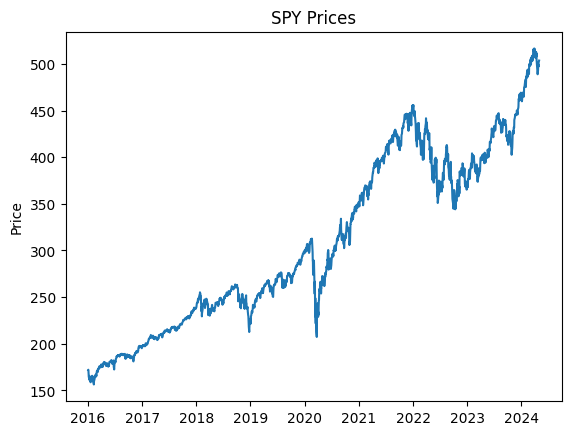

In [19]:
plt.plot(price_df['SPY'])
plt.title('SPY Prices')
plt.ylabel('Price')
plt.show()

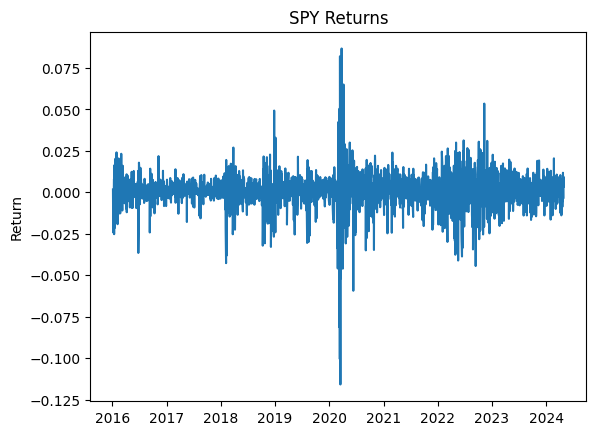

In [20]:
plt.plot(returns_df['SPY'])
plt.title('SPY Returns')
plt.ylabel('Return')
plt.show()

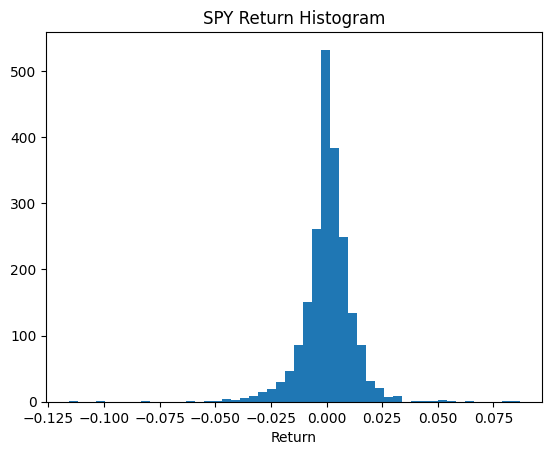

In [21]:
plt.hist(returns_df['SPY'],bins=50)
plt.title('SPY Return Histogram')
plt.xlabel('Return')
plt.show()

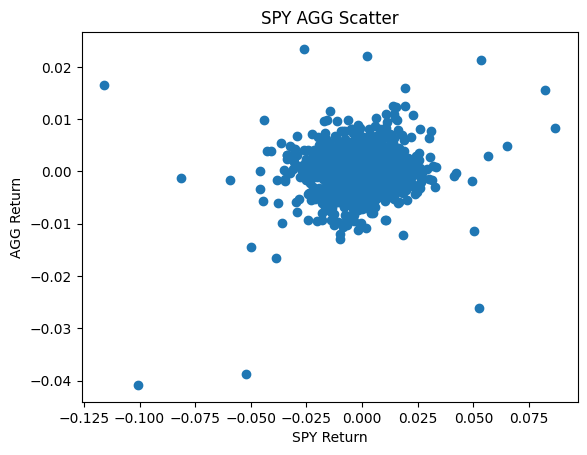

In [22]:
plt.scatter(x=returns_df['SPY'],y=returns_df['AGG'])
plt.title('SPY AGG Scatter')
plt.xlabel('SPY Return')
plt.ylabel('AGG Return')
plt.show()

## Predicting returns
... Turns out this is quite difficult.  Maybe close to impossible if we are only using price data.  Why?  Many market participants are all buying and selling the securities.  If more participants want to buy, the price goes up.  So, if we are only using information to make our prediction that the other participants have access to, we can expect that any utility from that information is already reflected in the price.

In [23]:
X_train = []
y_train = []
lag_obs = 30
test_obs = 5
n = returns_df.shape[0]
for i in np.arange(lag_obs,n-test_obs,1):
    date_range_x = returns_df.index[i-lag_obs:i]
    date_y = returns_df.index[i]
    for j in returns_df.columns:
        X_train.append(returns_df.loc[date_range_x,j].values)
        y_train.append(returns_df.loc[date_y,j])

X_test = []
y_test = []
for i in np.arange(n-test_obs,n,1):
    date_range_x = returns_df.index[i-lag_obs:i]
    date_y = returns_df.index[i]
    for j in returns_df.columns:
        X_test.append(returns_df.loc[date_range_x,j].values)
        y_test.append(returns_df.loc[date_y,j])

In [24]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((47334, 30), (47334,), (115, 30), (115,))

In [25]:
return_predictor_rf = RandomForestRegressor()
return_predictor_rf.fit(X_train,y_train)

RandomForestRegressor()

In [26]:
print('R-squared: ',r2_score(y_true=y_test,y_pred=return_predictor_rf.predict(X_test)))

R-squared:  -0.0015482356028206912


## Traditional portfolio optimization
Traditionally, one would construct a portfolio by first defining the distribution of returns.  This generally requires an assumption for the distribution.  For simplicity, we will assume the assets follow a multivariate normal distribution.  Much research shows that fatter tails are common, and for some assets, a normal distribution wouldn't make sense - but thsi is just for exposition.  A multivariate normal distribution is described by two parameters, row vector $\mu$ and matrix $\Sigma$.  $\mu$ is a vector of means for each of the random normals, and $\Sigma$ is a matrix of their covariances.  Recall that mean of a portfolio with allocations of column vector $x$ is $\mu x$ and the variances is $x^T\Sigma x$.

Once these parameters are set, then we can calculate various metrics, such as the expected return, the expected standard deviation, the sharpe ratio, the value-at-risk, etc.  We can use these metrics along with a solver, such as the solver in scipy, to minimize or maximize the metric's value over all feasible allocations.

In [27]:
def expected_return(x,mu):
    exp_return = x@mu
    return exp_return

def expected_std_dev(x,sigma):
    std_dev = np.sqrt(x@sigma@x)
    return std_dev

def expected_sharpe_ratio(x,mu,sigma,risk_free_rate=0):
    exp_return = expected_return(x,mu)
    std_dev = expected_std_dev(x,sigma)
    return -(exp_return-risk_free_rate)/std_dev

def standard_optim(mu,sigma,risk_free_rate=0):
    constraints=[{'type':'eq','fun':lambda x: x.sum(0)-1}]
    x0 = np.zeros_like(mu)
    x0[0] = 1
    bounds = tuple([(0,1) for i in x0])
    rslt = minimize(fun=expected_sharpe_ratio
                   ,x0=x0
                   ,constraints=constraints
                   ,args=(mu,sigma, risk_free_rate)
                   ,bounds=bounds)
    return rslt.x.round(2)

In [28]:
optimal_sharpe = standard_optim(mu,Sig)
{'optimal sharpe alloc':optimal_sharpe,
 'optimal sharpe return': expected_return(optimal_sharpe,mu),
 'optimal sharpe std': expected_std_dev(optimal_sharpe,Sig),
 'optimal sharpe sharpe': -expected_sharpe_ratio(optimal_sharpe,mu,Sig)
}

{'optimal sharpe alloc': array([0.69, 0.16, 0.09, 0.  , 0.06]),
 'optimal sharpe return': np.float64(0.0007008532999410185),
 'optimal sharpe std': np.float64(0.000549536594485965),
 'optimal sharpe sharpe': np.float64(1.2753532830631502)}

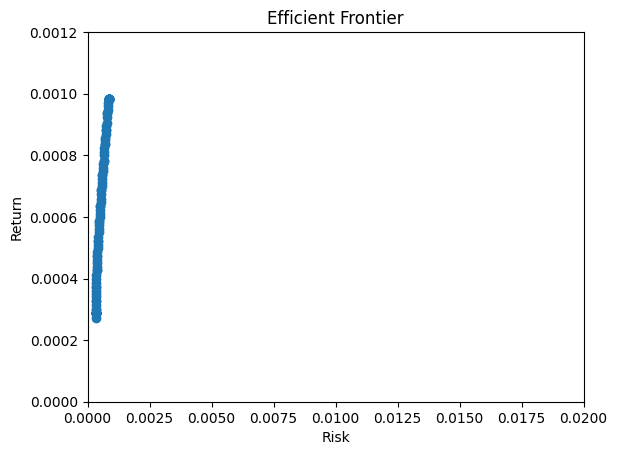

In [29]:
def risk_min(r,mu,sigma,risk_free_rate=0):
    constraints=[{'type':'eq','fun':lambda x: x.sum(0)-1} ## allocation sums to 1
                ,{'type':'ineq','fun':lambda x: expected_return(x,mu)-r} ## return above r
                ]
    x0 = np.zeros_like(mu)
    x0[0] = 1
    bounds = tuple([(0,1) for i in x0])
    rslt = minimize(fun=expected_std_dev
                   ,x0=x0
                   ,constraints=constraints
                   ,args=(sigma)
                   ,bounds=bounds)
    return rslt.x.round(2)

efficient_front = []
for i in np.arange(0.0001,0.0012,0.00001):
    alloc = risk_min(i,mu,Sig)
    alloc_ret = expected_return(alloc,mu)
    alloc_std = expected_std_dev(alloc,Sig)
    efficient_front.append([alloc_ret,alloc_std])
ef_df = pd.DataFrame(efficient_front,columns=['mu','std'])
plt.scatter(x=ef_df['std'],y=ef_df['mu'])
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.xlim(0,0.02)
plt.ylim(0,0.0012)
plt.ylabel('Return')
plt.show()

## Skipping estimation of parameters
Instead of explicitly estimating the parameters of the distribution for the asset returns, we can calculate historical metrics directly.  This can help us avoid some of the pitfalls of bad assumptions for the distribution, but it doesn't allow us to add in expert judgement about the value of the parameters (e.g. if we think a certain asset classes will have higher performance in the future).

In [30]:
def historical_sharpe_ratio(x,returns,risk_free_rate=0):
    port_return = returns@x
    port_mean = port_return.mean()
    port_std_dev = port_return.std()
    return -(port_mean-risk_free_rate)/port_std_dev

def data_optim(returns,risk_free_rate=0):
    constraints=[{'type':'eq','fun':lambda x: x.sum(0)-1}]
    x0 = np.zeros(shape=[returns.shape[1],])
    x0[0] = 1
    bounds = tuple([(0,1) for i in x0])
    rslt = minimize(fun=historical_sharpe_ratio
                   ,x0=x0
                   ,constraints=constraints
                   ,args=(returns, risk_free_rate)
                   ,bounds=bounds)
    return rslt.x.round(2)

In [31]:
data_optim(returns_df.values)

array([0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.5 , 0.  , 0.  , 0.  ,
       0.  , 0.26, 0.  , 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

## Very simple application of reinforcement learning
Another approach to finding an optimal asset allocation is to use reinforcement learning.

To start, let's think about the problem the same way we thought about it in the traditional setting - we want to maximize the historical sharpe ratio by selecting the best asset allocation.  To do this, we set the reward as the sharpe ratio and try and find the policy that will maximize it.  We will randomly sample 6 securities and ask the policy model to predict the optimal allocation (the one that maximizes sharpe).  We can do this many times by resampling from our 23 securities in a random order.

In [32]:
class InvestmentGame0(gym.Env):
    def __init__(self,returns,sec_cnt=6,risk_free_rate=0):
        self.sec_cnt = sec_cnt
        super(InvestmentGame0,self).__init__()
        self.action_space = spaces.Box(
            low=0,high=1,shape=(self.sec_cnt,),dtype=np.float32)
        self.observation_space=spaces.Box(
            low=-1, high=1, shape=([returns.shape[0],self.sec_cnt]),dtype=np.float32)
        self.reward_range=(-10,10)
        self.all_returns = returns
        self.risk_free_rate = risk_free_rate
        self.obs,_ = self.reset()

    def step(self,action):
        self.current_action = action
        if action.sum()==0:
            self.weights = (action+1)/self.sec_cnt
        else:
            self.weights = action/action.sum()

        port_returns = self.returns@self.weights
        sharpe = (port_returns.mean()-self.risk_free_rate)/port_returns.std()
        reward = sharpe.clip(-10,10)
        terminated = 1
        self.obs =self._get_obs()
        info = {"data":1}
        return obs,reward,terminated,0,info
    def reset(self,seed=None):
        if not seed is None:
            np.random.seed(seed)
        self.sec_smpl = np.random.choice(self.all_returns.columns,self.sec_cnt,replace=False)
        self.returns = self.all_returns[self.sec_smpl]
        self.obs = self._get_obs()
        return self.obs, {'data':1}
    def _get_obs(self):
        obs = self.returns
        return obs

In [33]:
env = DummyVecEnv([lambda: InvestmentGame0(returns_df)])
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                    net_arch=[dict(pi=[32,32,32,16,16],vf=[32,32,32,16,16])])
model0 = PPO(MlpPolicy, env, learning_rate=0.005, batch_size=200, gamma=1, n_steps=2000, policy_kwargs=policy_kwargs, verbose=1)
obs = env.reset()
model0.learn(total_timesteps=20000)

Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 421  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2000 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 289        |
|    iterations           | 2          |
|    time_elapsed         | 13         |
|    total_timesteps      | 4000       |
| train/                  |            |
|    approx_kl            | 0.05787143 |
|    clip_fraction        | 0.338      |
|    clip_range           | 0.2        |
|    entropy_loss         | -8.45      |
|    explained_variance   | -0.388     |
|    learning_rate        | 0.005      |
|    loss                 | -0.0788    |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.047     |
|    std                  | 0.982      |
|    value_loss           | 0.00104    |
----------------------------------------
-----------

In [34]:
env = InvestmentGame0(returns_df)
state, _ = env.reset()
action = model0.predict(state)[0]
new_state, reward, _, _, _ = env.step(action)
rslt0_df = pd.DataFrame(action/action.sum(),columns=['model result'])
rslt0_df['data optim result'] = data_optim(env.returns)
rslt0_df

,model result,data optim result
0,0.220100,0.00
1,0.000000,0.00
2,0.305242,0.57
3,0.305242,0.42
4,0.000000,0.01
5,0.169416,0.00


### Evaluating results
In addition to the many typical metrics provided for RL models, which are printed by stable-baselines3, we may want to evaluate our model based on the specific circumstances and objectives of our problem.

As can be seen, below, the policy model is not quite learning the exact allocation we get from the classical approach.  However, it is closer than a benchmark of just giving even weight to all of the options.

In [35]:
def alloc_predict(returns,model):
    raw_alloc = model.predict(returns)[0]
    if raw_alloc.sum() == 0:
        alloc = (raw_alloc+1)/returns.shape[1]
    else:
        alloc = raw_alloc/raw_alloc.sum()
    return alloc

sec_smpl = np.random.choice(returns_df.columns,6,replace=False)
rtn_smpl_df = returns_df[sec_smpl]
result_df = pd.DataFrame(alloc_predict(rtn_smpl_df.values,model0),index=rtn_smpl_df.columns,columns=['Model'])
result_df['Baseline(optim)'] = data_optim(rtn_smpl_df.values)
result_df['Difference'] = result_df['Model']-result_df['Baseline(optim)']
result_df

,Model,Baseline(optim),Difference
Ticker,,,
AGG,0.287711,0.45,-0.162289
SDY,0.060793,0.55,-0.489207
IBM,0.380002,0.00,0.380002
AA,0.000000,0.00,0.000000
IPAC,0.027387,0.00,0.027387
XLRE,0.244106,0.00,0.244106


In [36]:
def test_model_variance(model,obs,securities,returns,N=1000):
    variance = []
    benchmark = []
    total_obs = returns.shape[0]
    for i in range(N):
        sec_smpl = np.random.choice(returns_df.columns,6,replace=False)
        rtn_smpl_df = returns_df[sec_smpl]
        predict_alloc = alloc_predict(rtn_smpl_df,model)
        optimal_alloc = data_optim(rtn_smpl_df)
        variance.append(((predict_alloc-optimal_alloc)**2).sum())
        benchmark.append(((0.2-optimal_alloc)**2).sum())
    return {'mean model difference to benchmark':np.mean(variance)
            , 'mean even split difference to benchmark':np.mean(benchmark)}

test_model_variance(model0,returns_df.shape[0],returns_df.shape[1],returns_df)

{'mean model difference to benchmark': np.float64(0.2988814751653185),
 'mean even split difference to benchmark': np.float64(0.3979444000000001)}

### Looking at the rewards
Another way to evaluate the model is to compare the reward against the classical approach.  We can also compare against a random allocation and an even split.  The model is doing well against the random allocation and even split - so it is learning - but it is not quite to the level of the classical approach.  Given enough tuning, it can probably achieve results on par with the classical approach.  However, it won't beat it in this case - because of how we set up the problem, the classical approach is truly a global optimal.

In [37]:
def policy_tester(environment,policy_model,sec_cnt=6,N=1000,returns=None):
    if returns is None:
        env = environment()
    else:
        env = environment(returns)
    obs,_ = env.reset()
    #model return
    total_reward = 0
    for i in range(N):
        obs,reward,term,_,_ = env.step(policy_model.predict(obs)[0])
        total_reward += reward
        if term==1:
            obs,_ = env.reset()
    model_reward = total_reward
    ##benchmark return
    total_reward = 0
    obs,_ = env.reset()
    for i in range(N):
        obs,reward,term,_,_ = env.step(data_optim(env.returns))
#         obs,reward,term,_,_ = env.step(data_optim(obs))
        total_reward += reward
        if term==1:
            obs,_ = env.reset()
    benchmark_reward = total_reward
    ## random return
    total_reward = 0
    obs,_ = env.reset()
    for i in range(N):
        random_alloc = np.random.dirichlet(np.ones(shape=[env.returns.shape[1]]))
        obs,reward,term,_,_ = env.step(random_alloc)
        total_reward += reward
        if term==1:
            obs,_ = env.reset()
    random_reward = total_reward
    ## even split return
    total_reward = 0
    obs,_ = env.reset()
    for i in range(N):
        even_alloc = np.ones(shape=[env.returns.shape[1]])/env.returns.shape[1]
        obs,reward,term,_,_ = env.step(even_alloc)
        total_reward += reward
        if term==1:
            obs,_ = env.reset()
    even_split_reward = total_reward
    return {'model reward':model_reward,
            'benchmark reward':benchmark_reward,
            'random reward':random_reward,
            'simple split reward':even_split_reward}

In [38]:
policy_tester(InvestmentGame0,model0,returns=returns_df)

{'model reward': np.float64(45.33646950691248),
 'benchmark reward': np.float64(51.81955015900652),
 'random reward': np.float64(28.59430923347723),
 'simple split reward': np.float64(30.079024771448)}

## A (more) realistic (and interesting) scenario
Unlike our previous example, we can set up a more complex example where the customer has a slightly more complex utility and is concerned about multiple investign over multiple periods.  Having many periods allows for market conditions to change.  In addition, there is now a cost associated with changing an asset allocation, forcing a decision about whether revising the allocation is worth the cost.  This requires us to set this environment up to persist over a period of time (90 periods in this example).

To set this up, we pick a random date with enough observations for history (300), then we increment forward 90 days - each time we update the allocation, calculate the trading cost, and subtract that from the total returns.

We could add additional complexities to the environment as well, such as assets with contingent or deferred payoffs, adversion to risk, taxes, additional data sources, etc.  This is where ML methods can really add value.  There is not likely to be a clear global optimal, and the policy model can now beat the classical approach.

In this example, we give the policy model the classical optimal allocation as part of the state space - why make the model do the extra work!?

In [39]:
class InvestmentGame1(gym.Env):
    """"""
    def __init__(self,return_data,sec_cnt=6,risk_free_rate=0,N=300,T=90):
        """
        initialize environment
        """
        super(InvestmentGame1,self).__init__()
        self.all_returns = return_data
        self.N = N
        self.sec_cnt = sec_cnt
        self.obs_cnt = return_data.shape[0]
        self.securities = self.sec_cnt

        self.action_space = spaces.Box(
            low=0,high=1,shape=(self.sec_cnt,),dtype=np.float32)
        ## obs space will be time + current alloc + optimal alloc using traditional methods + mean and std of returns
        self.observation_space=spaces.Box(
            low=-1, high=1, shape=(1+self.sec_cnt*4,),dtype=np.float32)
        self.reward_range=(-2,2)
        self.N = N
        self.T = T

        self.risk_free_rate = risk_free_rate

        self.obs,_ = self.reset()

    def step(self,action):
        """
        action is the change in weights at the beginning of the period
        reward based on returns in the current period
        final weights are updated based on action and the realized returns in the period
        """
        self.current_action = action
        if self.current_action.sum()==0:
            self.new_weights = (self.current_action+1)/self.securities
        else:
            self.new_weights = self.current_action/self.current_action.sum() ## ensure they sum to 1

        self.time += 1
        change_in_port = np.abs(self.new_weights - self.weights).sum()
        cost = 0.002*change_in_port

        dates = self.all_returns.index[self.t-self.N+self.time:self.t+self.time]
        self.returns = self.all_returns.loc[dates
                                        ,self.sec_smpl].values
        port_returns = self.returns[-1,:]@self.new_weights.reshape(-1,) ## returns in current period

        self.weights = (1+self.returns[-1,:])*self.new_weights

        reward = port_returns - cost
        self.time += 1
        obs = self._get_obs()

        if self.time == self.T:
            terminated = 1
        else:
            terminated = 0

        info = {"data":1}
        return obs,reward,terminated,0,info

    def reset(self,seed=None):
        """
        reset the environment"""
        if not seed is None:
            np.random.seed(seed)

        self.sec_smpl = np.random.choice(self.all_returns.columns,self.sec_cnt,replace=False)

        self.t = self._get_rnd_dt()
        dates = self.all_returns.index[self.t-self.N:self.t] ## just the N observations between t-N and t
        self.returns = self.all_returns.loc[dates
                                            ,self.sec_smpl
                                           ].values

        self.weights = np.random.dirichlet(np.ones(shape=[self.securities,]))  #initial weights are random

        self.time = 0

        obs = self._get_obs()

        return obs, {'data':1}

    def _get_obs(self):
        """
        stack the following
        time
        weights
        optimal weights using traditional methods
        returns
        """
        optimal_weights = data_optim(self.returns)
        obs = np.hstack((self.time/self.T
                         ,self.weights
                         ,optimal_weights
                         ,self.returns.mean(0)
                         ,self.returns.std(0)))
        return obs

    def _get_rnd_dt(self):
        """"""
        rnd = np.random.choice(range(self.N,self.obs_cnt-self.T))
        return(rnd)

In [40]:
env = DummyVecEnv([lambda: InvestmentGame1(returns_df)])
policy_kwargs = dict(activation_fn=th.nn.ReLU,
                    net_arch=[dict(pi=[32,32,16,16],vf=[32,32,16,16])])
model1 = PPO(MlpPolicy, env, learning_rate=0.0001, batch_size=512, gamma=.99, n_steps=5096
             , policy_kwargs=policy_kwargs, verbose=1)
obs = env.reset()
model1.learn(total_timesteps=400000)

Using cpu device


/usr/local/lib/python3.11/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 5096`, after every 9 untruncated mini-batches, there will be a truncated mini-batch of size 488
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=5096 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 70   |
|    iterations      | 1    |
|    time_elapsed    | 72   |
|    total_timesteps | 5096 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 67            |
|    iterations           | 2             |
|    time_elapsed         | 150           |
|    total_timesteps      | 10192         |
| train/                  |               |
|    approx_kl            | 0.00036561728 |
|    clip_fraction        | 2.05e-05      |
|    clip_range           | 0.2           |
|    entropy_loss         | -8.51         |
|    explained_variance   | -3.97         |
|    learning_rate        | 0.0001        |
|    loss                 | 0.00111       |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000842     |
|    std                  | 0.999         |
|    value_loss           | 0.0165        

In [41]:
env = InvestmentGame1(returns_df)
state, _ = env.reset()
action = model1.predict(state)[0]
rslt1_df = pd.DataFrame(action/action.sum(),columns=['model result'])
rslt1_df['begin_alloc'] = state[1:7]
rslt1_df['data optim result'] = data_optim(env.returns)
rslt1_df

,model result,begin_alloc,data optim result
0,0.240501,0.010224,1.0
1,0.000000,0.021199,0.0
2,0.037996,0.122309,0.0
3,0.240501,0.543156,0.0
4,0.240501,0.161359,0.0
5,0.240501,0.141753,0.0


### Get used to disappointment
In this example, the policy model we learned is still not sufficient to out-perform the traditional optimization approach.  Keep this in mind - machine learning in financial markets is difficult.  There are a few fundamental reasons for this.  First, there is limited data and it is very easy to overfit to limited historical examples.  Second, there are many market participants all looking to get an edge - if an opportunity is discovered, it is quickly exploited and will disappear.  In other words, the data are not stationary - the markets keep adapting based on the behavior of market participants (as well as to changing in policy set by governing bodies).

In [42]:
policy_tester(InvestmentGame1,model1,returns=returns_df)

{'model reward': np.float64(-1.200561915601712),
 'benchmark reward': np.float64(0.3120236748946758),
 'random reward': np.float64(-1.3411967008536707),
 'simple split reward': np.float64(0.47017820545634037)}